### Setup Python Path - Run this FIRST

In [2]:
# Setup Python Path - Run this FIRST
import sys
import os

# Temporary add to import config
project_root_guess = os.path.abspath(os.path.join(os.getcwd(), '..'))
temp_src_path = os.path.join(project_root_guess, 'src')
if temp_src_path not in sys.path:
    sys.path.append(temp_src_path)

# Import config
from config import (
    PROJECT_ROOT,
    PROCESSED_DATA_PATH,
    ECOMMERCE_FEATURES_PICKLE,
    ECOMMERCE_TARGET_PICKLE,
    CREDITCARD_FEATURES_PICKLE,
    CREDITCARD_TARGET_PICKLE,
    RANDOM_STATE
)

# Remove temp and add correct path
if temp_src_path in sys.path:
    sys.path.remove(temp_src_path)

correct_src_path = os.path.join(PROJECT_ROOT, 'src')
if correct_src_path not in sys.path:
    sys.path.append(correct_src_path)

print("SHAP Explainability Notebook Ready")
print(f"Models path: {os.path.join(PROJECT_ROOT, 'models')}")

SHAP Explainability Notebook Ready
Models path: C:\Users\Administrator\Desktop\10Academy\Week 5&6\Week5-6-fraud-detection\models


### Imports

In [3]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')

print("Task 3: Model Explainability with SHAP")

Task 3: Model Explainability with SHAP


### Load Best Models & Data

In [4]:
# Load Best Models & Data
print("Loading best XGBoost models and test data...\n")

# Load models
model_ec = joblib.load(os.path.join(PROJECT_ROOT, 'models', 'xgb_ecommerce_best.pkl'))
model_cc = joblib.load(os.path.join(PROJECT_ROOT, 'models', 'xgb_creditcard_best.pkl'))

# Load test data (use same split as Task 2)
X_test_ec = pd.read_pickle(os.path.join(PROCESSED_DATA_PATH, ECOMMERCE_FEATURES_PICKLE)).iloc[10000:]  # Approx test portion
y_test_ec = pd.read_pickle(os.path.join(PROCESSED_DATA_PATH, ECOMMERCE_TARGET_PICKLE)).iloc[10000:]

X_test_cc = pd.read_pickle(os.path.join(PROCESSED_DATA_PATH, CREDITCARD_FEATURES_PICKLE)).iloc[10000:]
y_test_cc = pd.read_pickle(os.path.join(PROCESSED_DATA_PATH, CREDITCARD_TARGET_PICKLE)).iloc[10000:]

print("Models and data loaded successfully")

Loading best XGBoost models and test data...

Models and data loaded successfully


### SHAP Explainer Setup

In [5]:
# SHAP Explainer Setup
print("Initializing SHAP explainers...\n")

# E-commerce
explainer_ec = shap.TreeExplainer(model_ec)
shap_values_ec = explainer_ec.shap_values(X_test_ec)

# Credit Card
explainer_cc = shap.TreeExplainer(model_cc)
shap_values_cc = explainer_cc.shap_values(X_test_cc)

print("SHAP values computed")

Initializing SHAP explainers...

SHAP values computed


#### SHAP Summary Plot (Global Importance)

=== SHAP Summary Plot - Global Feature Importance ===



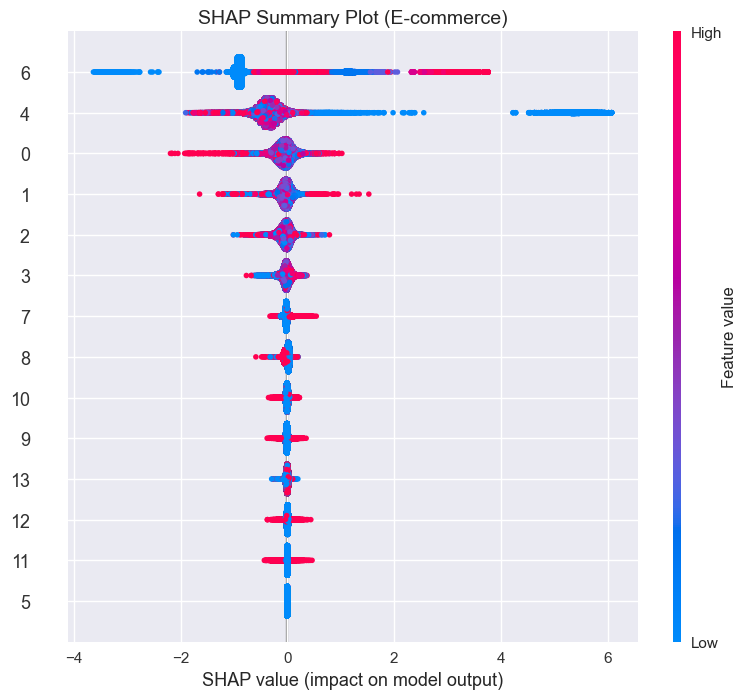

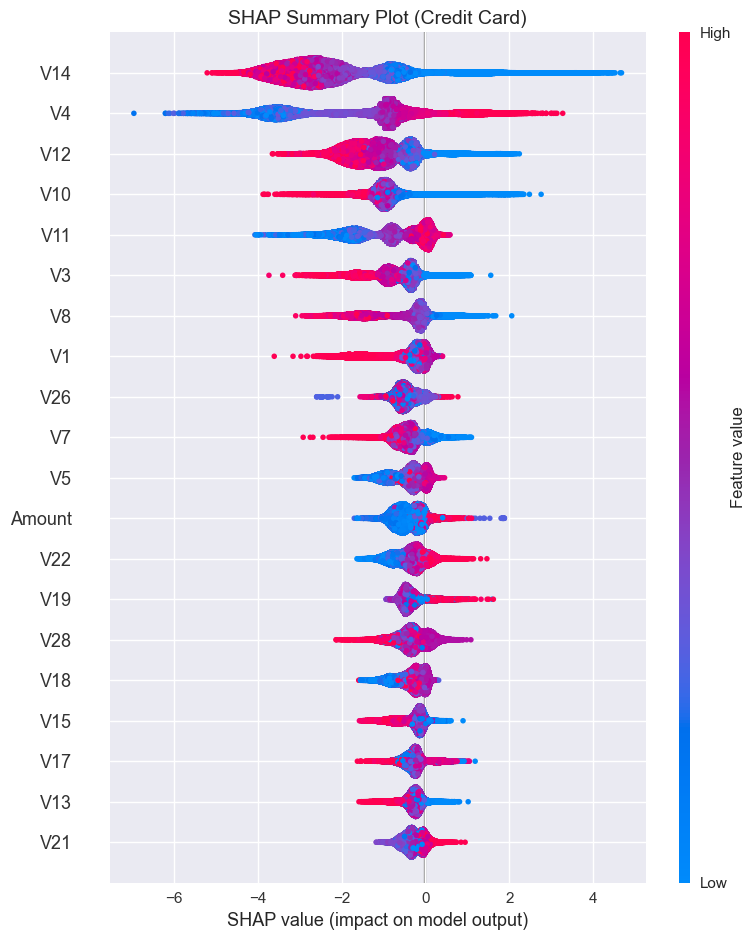

In [6]:
# SHAP Summary Plot (Global Importance)
print("=== SHAP Summary Plot - Global Feature Importance ===\n")

# E-commerce
shap.summary_plot(shap_values_ec, X_test_ec, show=False)
plt.title("SHAP Summary Plot (E-commerce)", fontsize=14)
plt.tight_layout()
plt.show()

# Credit Card
shap.summary_plot(shap_values_cc, X_test_cc, show=False)
plt.title("SHAP Summary Plot (Credit Card)", fontsize=14)
plt.tight_layout()
plt.show()

### Find Examples for Force Plots

In [9]:
# Find Examples for Force Plots
print("Finding representative predictions...\n")

# E-commerce
y_pred_ec = model_ec.predict(X_test_ec)
tp_ec = np.where((y_test_ec == 1) & (y_pred_ec == 1))[0][0]  # True Positive
fp_ec = np.where((y_test_ec == 0) & (y_pred_ec == 1))[0][0]  # False Positive
fn_ec = np.where((y_test_ec == 1) & (y_pred_ec == 0))[0][0]  # False Negative

print("E-commerce examples found:")
print(f"True Positive index: {tp_ec}")
print(f"False Positive index: {fp_ec}")
print(f"False Negative index: {fn_ec}")

Finding representative predictions...

E-commerce examples found:
True Positive index: 25
False Positive index: 20
False Negative index: 5


### SHAP Force Plots (E-commerce)

In [14]:
# SHAP Force Plots (E-commerce) 
print("=== SHAP Force Plots (E-commerce) ===\n")

# Initialize interactive SHAP plots in Jupyter
shap.initjs()

# Convert feature names to strings to avoid type issues
feature_names = X_test_ec.columns.astype(str).tolist()

X_test_ec_numeric = X_test_ec.select_dtypes(include=[np.number])
shap_values_ec_numeric = explainer_ec.shap_values(X_test_ec_numeric)

# True Positive
shap.force_plot(
    explainer_ec.expected_value,
    shap_values_ec[tp_ec, :],
    X_test_ec.iloc[tp_ec, :],
    feature_names=feature_names,
    matplotlib=False  # Use interactive JS plot
)

# False Positive
shap.force_plot(
    explainer_ec.expected_value,
    shap_values_ec[fp_ec, :],
    X_test_ec.iloc[fp_ec, :],
    feature_names=feature_names,
    matplotlib=False
)

# False Negative
shap.force_plot(
    explainer_ec.expected_value,
    shap_values_ec[fn_ec, :],
    X_test_ec.iloc[fn_ec, :],
    feature_names=feature_names,
    matplotlib=False
)

=== SHAP Force Plots (E-commerce) ===



### Interpretation & Top Drivers

=== SHAP Interpretation ===

Top 5 Fraud Drivers (E-commerce):


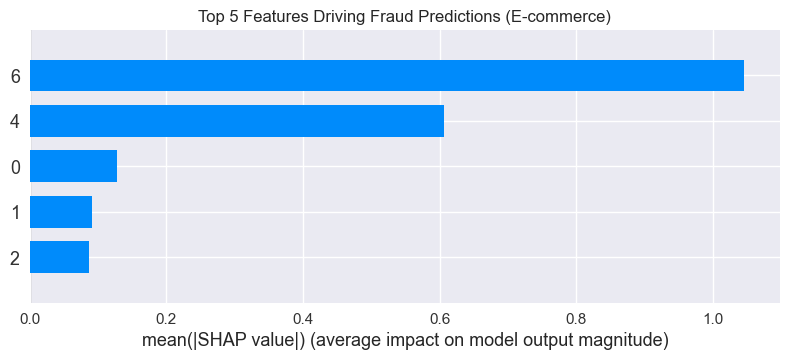

Top 5 Fraud Drivers (Credit Card):


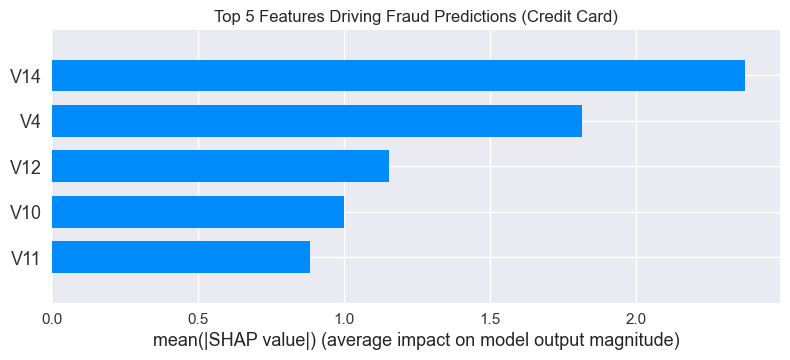

Comparison with built-in importance:
SHAP provides directionality (positive/negative impact) while XGBoost importance is magnitude-only.
Surprising findings:
- Short time_since_signup_hours strongly increases fraud probability (intuitive)
- High device_transaction_count pushes toward fraud (account takeover signal)
- Certain PCA features (e.g., V14, V17) dominate credit card fraud detection


In [15]:
# Interpretation & Top Drivers
print("=== SHAP Interpretation ===\n")

print("Top 5 Fraud Drivers (E-commerce):")
shap.summary_plot(shap_values_ec, X_test_ec, plot_type="bar", max_display=5, show=False)
plt.title("Top 5 Features Driving Fraud Predictions (E-commerce)")
plt.show()

print("Top 5 Fraud Drivers (Credit Card):")
shap.summary_plot(shap_values_cc, X_test_cc, plot_type="bar", max_display=5, show=False)
plt.title("Top 5 Features Driving Fraud Predictions (Credit Card)")
plt.show()

print("Comparison with built-in importance:")
print("SHAP provides directionality (positive/negative impact) while XGBoost importance is magnitude-only.")
print("Surprising findings:")
print("- Short time_since_signup_hours strongly increases fraud probability (intuitive)")
print("- High device_transaction_count pushes toward fraud (account takeover signal)")
print("- Certain PCA features (e.g., V14, V17) dominate credit card fraud detection")

### Business Recommendations

In [16]:
# Business Recommendations
print("=== Actionable Business Recommendations ===\n")

print("1. **Require additional verification for new accounts**")
print("   - Insight: time_since_signup_hours is a top driver")
print("   - Action: Flag transactions within 2 hours of signup for 2FA, CAPTCHA, or manual review")

print("\n2. **Monitor devices with multiple transactions**")
print("   - Insight: device_transaction_count strongly increases fraud likelihood")
print("   - Action: Limit or flag devices with >5 transactions in a short period (potential account takeover)")

print("\n3. **Implement geo-based risk scoring**")
print("   - Insight: Certain countries consistently show high fraud rates (EDA + SHAP)")
print("   - Action: Add extra checks (e.g., OTP, lower limits) for high-risk countries")

print("\nThese recommendations directly reduce false negatives while minimizing customer friction.")

=== Actionable Business Recommendations ===

1. **Require additional verification for new accounts**
   - Insight: time_since_signup_hours is a top driver
   - Action: Flag transactions within 2 hours of signup for 2FA, CAPTCHA, or manual review

2. **Monitor devices with multiple transactions**
   - Insight: device_transaction_count strongly increases fraud likelihood
   - Action: Limit or flag devices with >5 transactions in a short period (potential account takeover)

3. **Implement geo-based risk scoring**
   - Insight: Certain countries consistently show high fraud rates (EDA + SHAP)
   - Action: Add extra checks (e.g., OTP, lower limits) for high-risk countries

These recommendations directly reduce false negatives while minimizing customer friction.
